[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6716 - loss: 0.6369 - val_accuracy: 0.9090 - val_loss: 0.2529
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9149 - loss: 0.2300 - val_accuracy: 0.9366 - val_loss: 0.1765
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9564 - loss: 0.1344 - val_accuracy: 0.9477 - val_loss: 0.1453
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9707 - loss: 0.0961 - val_accuracy: 0.9542 - val_loss: 0.1271
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9811 - loss: 0.0647 - val_accuracy: 0.9613 - val_loss: 0.1104
238/238 ━━━━━━━━━━━━━━━━━━━━ 74s 308ms/step
LSTM - Test Loss: 0.1104, Test Accuracy: 0.9613

Training CNN model...
Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.6740 - loss: 0.6567 - val_accuracy: 0.8887 - val_loss: 0.3124
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9054 - loss: 0.2607 - val_accuracy: 0.9385 - val_loss: 0.1721
Epo

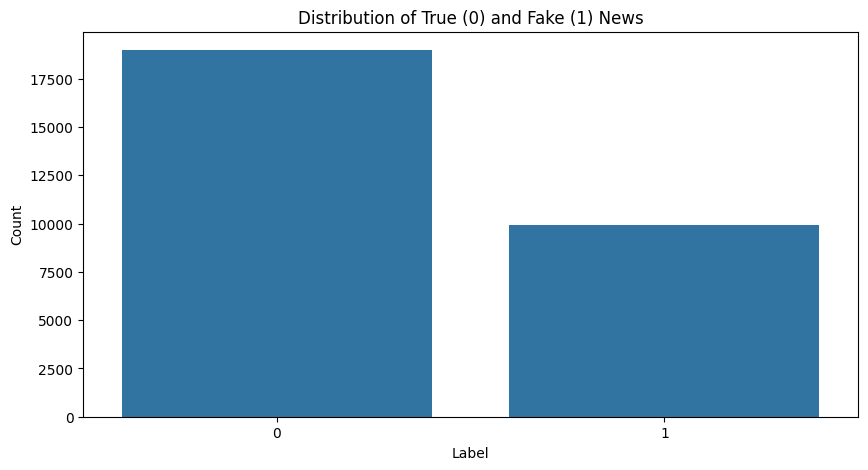

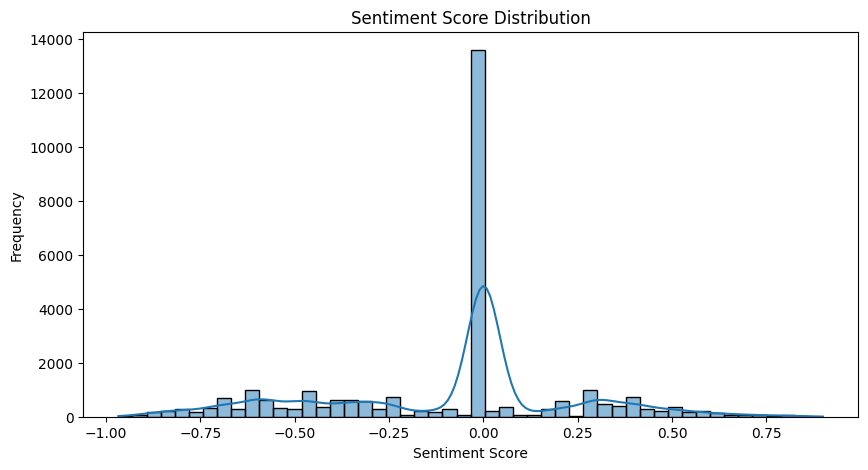

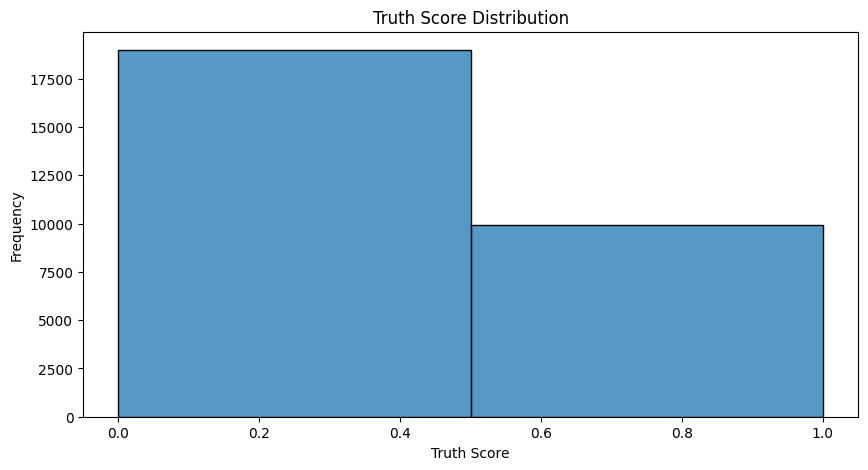

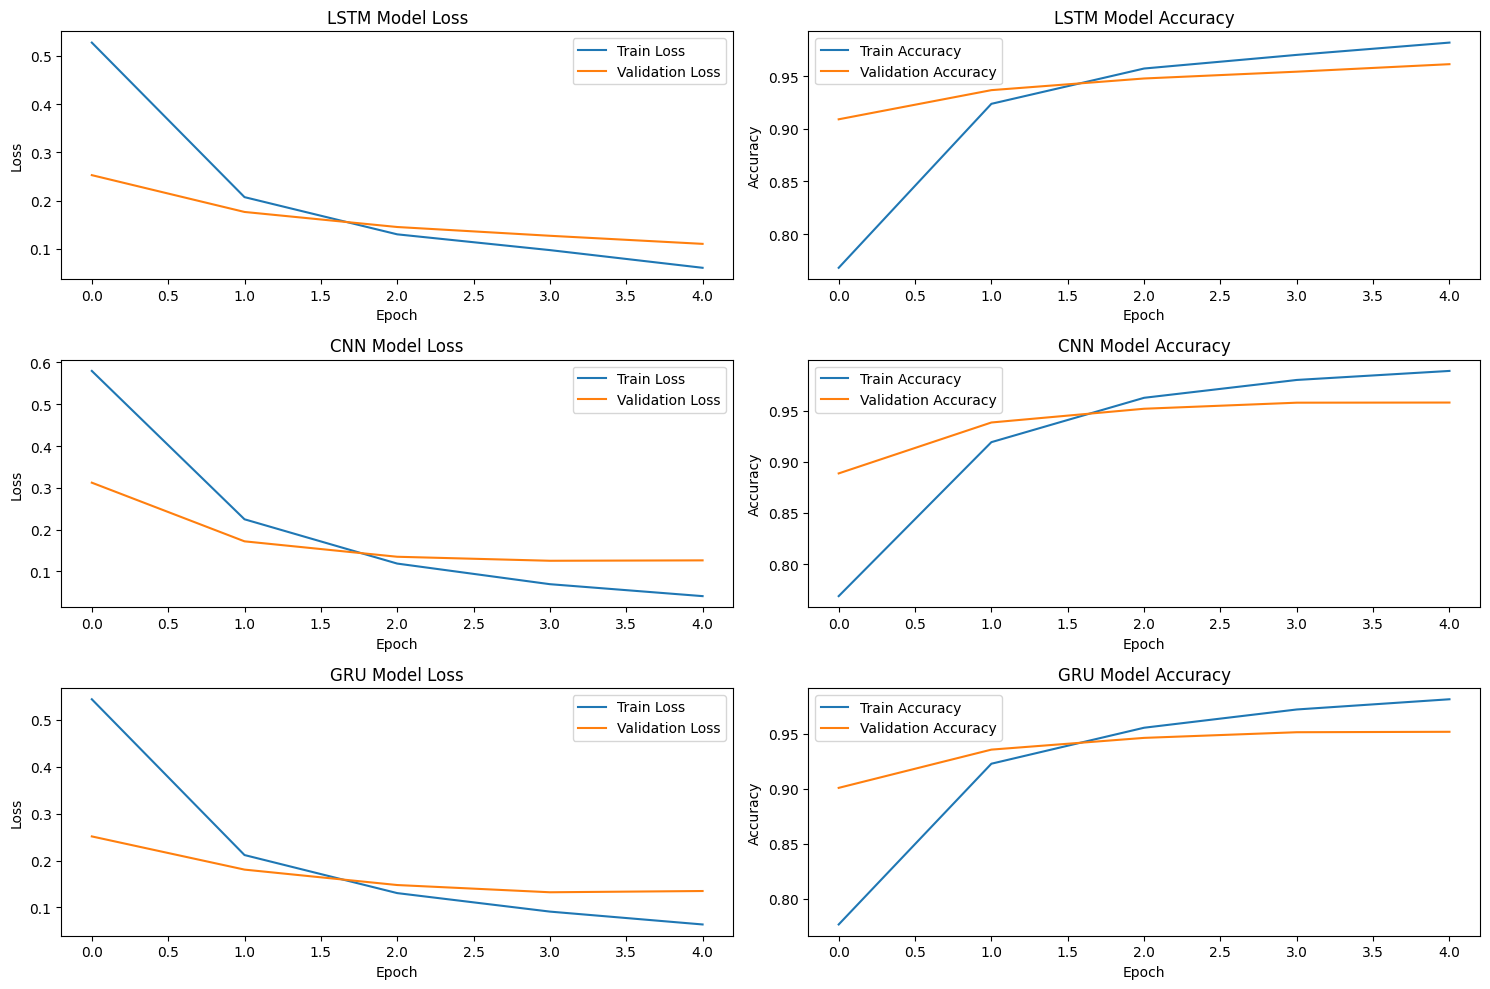

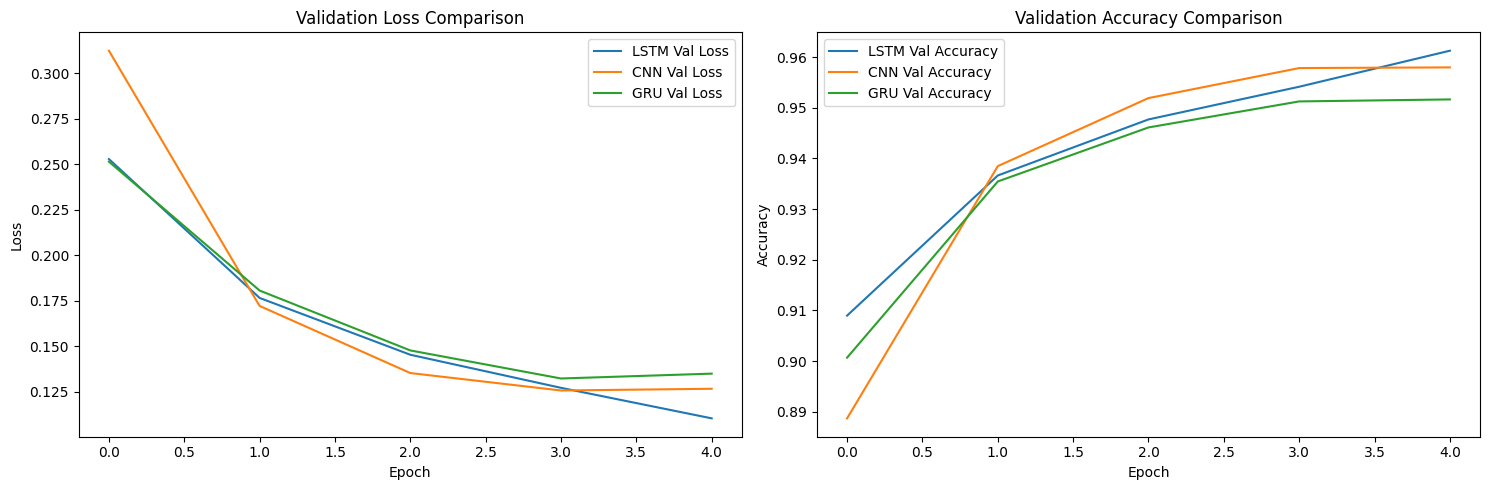

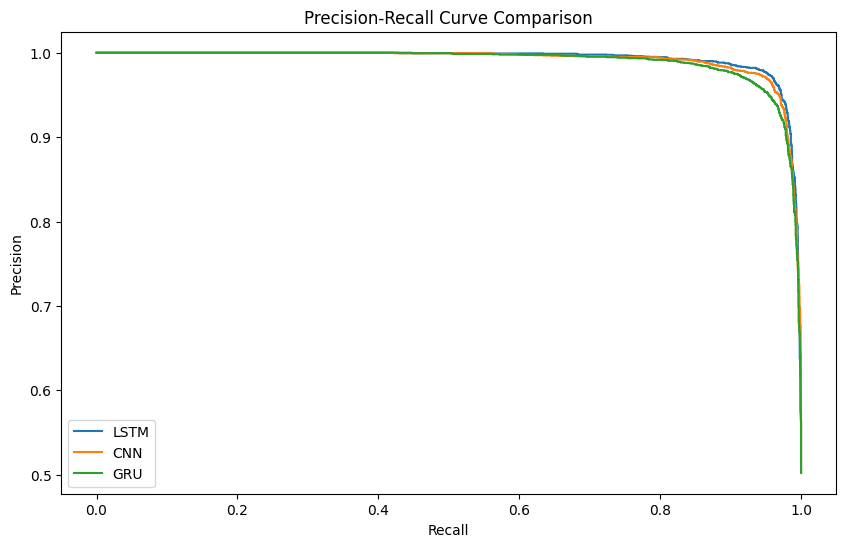

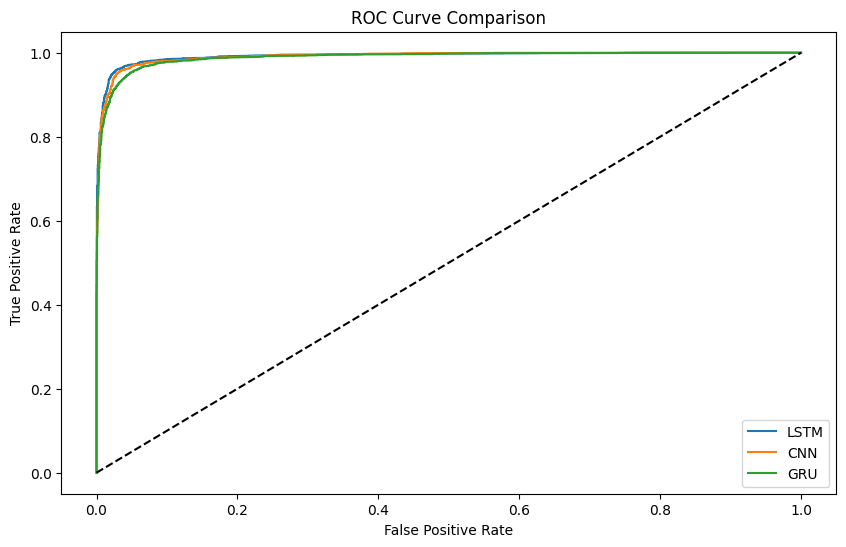

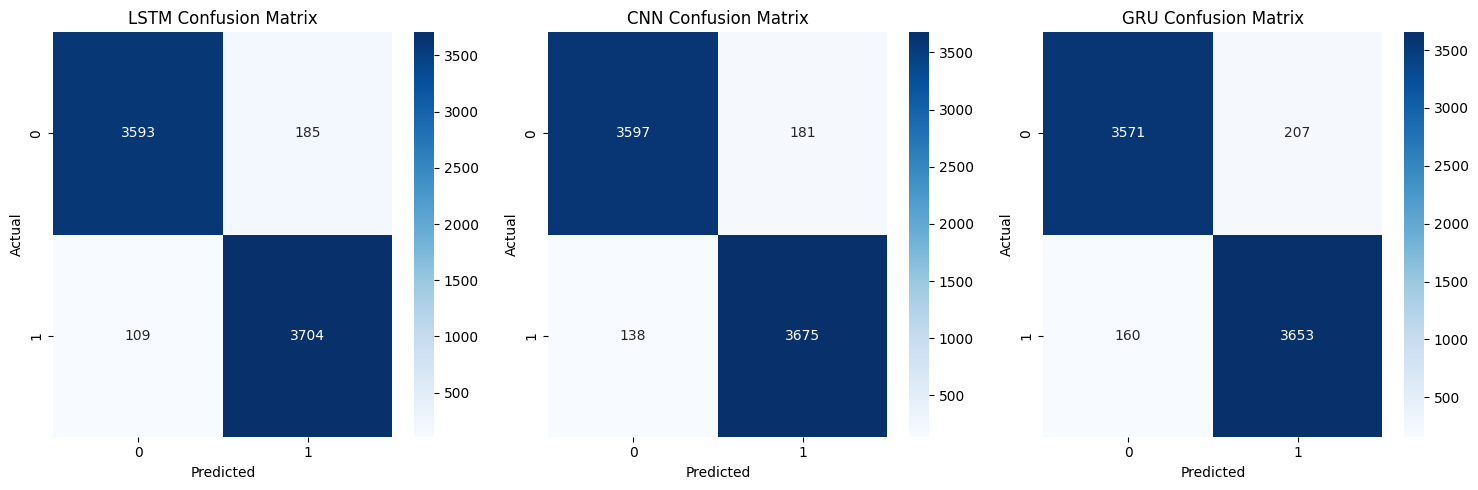

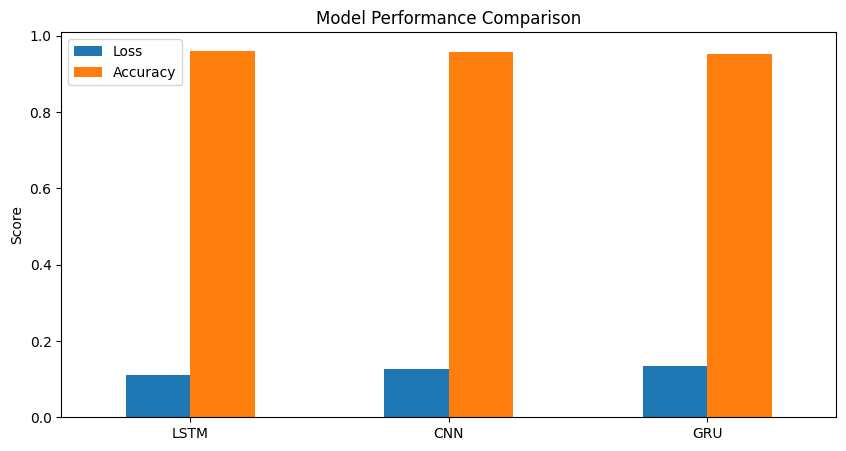

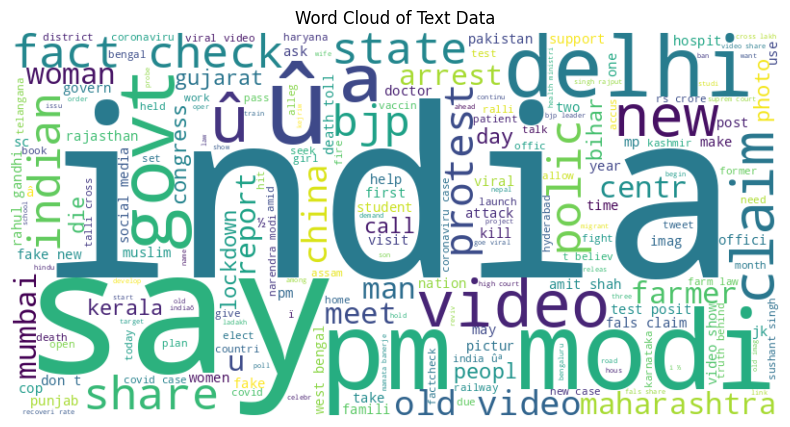


Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3778
           1       0.95      0.97      0.96      3813

    accuracy                           0.96      7591
   macro avg       0.96      0.96      0.96      7591
weighted avg       0.96      0.96      0.96      7591


Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3778
           1       0.95      0.96      0.96      3813

    accuracy                           0.96      7591
   macro avg       0.96      0.96      0.96      7591
weighted avg       0.96      0.96      0.96      7591


Classification Report for GRU:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3778
           1       0.95      0.96      0.95      3813

    accuracy                           0.95      7591
   macro avg       0.95      0.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate, Dropout, Conv1D, GlobalMaxPooling1D, GRU
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, classification_report
from wordcloud import WordCloud
import seaborn as sns
import gc

# Download required NLTK datasets
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load CSV data (assumes files 'true.csv' and 'fake.csv' are in the working directory)
true = pd.read_csv("true.csv")
fake = pd.read_csv("fake.csv")

# Rename columns to ensure consistency
true.rename(columns=lambda x: x.strip().lower(), inplace=True)
fake.rename(columns=lambda x: x.strip().lower(), inplace=True)

# Define custom layer for automatic fusion of two numerical features
class WeightedFusion(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WeightedFusion, self).__init__(**kwargs)

    def build(self, input_shape):
        # Expecting two inputs, each of shape (batch_size, 1)
        self.w1 = self.add_weight(name='w1', shape=(1,), initializer='uniform', trainable=True)
        self.w2 = self.add_weight(name='w2', shape=(1,), initializer='uniform', trainable=True)
        self.bias = self.add_weight(name='bias', shape=(1,), initializer='zeros', trainable=True)
        super(WeightedFusion, self).build(input_shape)

    def call(self, inputs):
        truth, sentiment = inputs
        return self.w1 * truth + self.w2 * sentiment + self.bias

# Create labels: true news = 0, fake news = 1
true['label'] = 0
fake['label'] = 1

# Combine and shuffle data
df = pd.concat([true, fake], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

# Define text cleaning function
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

# Clean the 'text' column
df['text'] = df['text'].apply(clean)

# Set truth_score exactly as label (true news = 0, fake news = 1)
df['truth_score'] = df['label']

# Sentiment analysis using VADER
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# NOTE: We do NOT compute a fused emotional_bias here; we want to keep truth_score and sentiment separate.

# Prepare text sequences using Tokenizer
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=max_len)

# Get the two numerical features as an array: truth_score and sentiment
num_features = df[['truth_score', 'sentiment']].values

# Combine the text sequences and numerical features for oversampling
X_combined = np.hstack([padded, num_features])
y = df['label'].values

# Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_combined, y)

# Free up memory (excluding df for word cloud)
del padded, num_features, sequences
gc.collect()

# Separate the text sequences and numerical features after oversampling
X_text_res = X_res[:, :max_len]
# The next two columns correspond to truth_score and sentiment, respectively
X_truth_res = X_res[:, max_len].reshape(-1, 1)
X_sentiment_res = X_res[:, max_len+1].reshape(-1, 1)

# Split into training and test sets
X_text_train, X_text_test, X_truth_train, X_truth_test, X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(
    X_text_res, X_truth_res, X_sentiment_res, y_res, test_size=0.2, random_state=42
)

# Define model creation function with automatic numerical fusion
def create_model(model_type, max_len, max_words):
    # Text branch
    text_input = Input(shape=(max_len,), name="text_input")
    embedding_layer = Embedding(input_dim=max_words, output_dim=16, input_length=max_len)(text_input)

    if model_type == 'LSTM':
        x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)
    elif model_type == 'CNN':
        x = Conv1D(64, 5, activation='relu')(embedding_layer)
        x = GlobalMaxPooling1D()(x)
    elif model_type == 'GRU':
        x = Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)
    else:
        raise ValueError("Unsupported model type. Choose from 'LSTM', 'CNN', or 'GRU'.")

    # Numerical branch for truth_score and sentiment
    truth_input = Input(shape=(1,), name="truth_input")
    sentiment_input = Input(shape=(1,), name="sentiment_input")

    # Fuse the two numerical inputs automatically
    fused_numerical = WeightedFusion(name="weighted_fusion")([truth_input, sentiment_input])

    # Concatenate text branch output with fused numerical feature
    combined = Concatenate()([x, fused_numerical])
    dense1 = Dense(64, activation='relu')(combined)
    drop1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(drop1)

    model = Model(inputs=[text_input, truth_input, sentiment_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate all models
model_types = ['LSTM', 'CNN', 'GRU']
histories = {}
predictions = {}
metrics_dict = {}

for model_type in model_types:
    print(f"Training {model_type} model...")
    model = create_model(model_type, max_len, max_words)
    history = model.fit(
        {'text_input': X_text_train, 'truth_input': X_truth_train, 'sentiment_input': X_sentiment_train},
        y_train,
        epochs=5,
        batch_size=512,
        validation_data=({'text_input': X_text_test, 'truth_input': X_truth_test, 'sentiment_input': X_sentiment_test}, y_test),
        verbose=1
    )
    histories[model_type] = history

    # Evaluate and predict
    loss, accuracy = model.evaluate({'text_input': X_text_test, 'truth_input': X_truth_test, 'sentiment_input': X_sentiment_test}, y_test, verbose=0)
    y_pred = model.predict({'text_input': X_text_test, 'truth_input': X_truth_test, 'sentiment_input': X_sentiment_test}).ravel()
    predictions[model_type] = y_pred
    metrics_dict[model_type] = {'loss': loss, 'accuracy': accuracy}
    print(f"{model_type} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}\n")

# Visualizations

# 1. Data Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df)
plt.title('Distribution of True (0) and Fake (1) News')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 2. Sentiment Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['sentiment'], bins=50, kde=True)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# 3. Truth Score Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['truth_score'], bins=2, kde=False)
plt.title('Truth Score Distribution')
plt.xlabel('Truth Score')
plt.ylabel('Frequency')
plt.show()

# 4. Training History Comparison (Loss and Accuracy)
plt.figure(figsize=(15, 10))
for i, model_type in enumerate(model_types, 1):
    history = histories[model_type]

    plt.subplot(3, 2, 2*i-1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2*i)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout()
plt.show()

# 5. Comparison of Loss and Accuracy Across Models
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for model_type in model_types:
    plt.plot(histories[model_type].history['val_loss'], label=f'{model_type} Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for model_type in model_types:
    plt.plot(histories[model_type].history['val_accuracy'], label=f'{model_type} Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Precision-Recall Curve Comparison
plt.figure(figsize=(10, 6))
for model_type in model_types:
    precision, recall, _ = precision_recall_curve(y_test, predictions[model_type])
    plt.plot(recall, precision, label=f'{model_type}')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 7. ROC Curve Comparison
plt.figure(figsize=(10, 6))
for model_type in model_types:
    fpr, tpr, _ = roc_curve(y_test, predictions[model_type])
    plt.plot(fpr, tpr, label=f'{model_type}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 8. Confusion Matrix for Each Model
plt.figure(figsize=(15, 5))
for i, model_type in enumerate(model_types, 1):
    cm = confusion_matrix(y_test, (predictions[model_type] > 0.5).astype(int))
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_type} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 9. Bar Plot of Final Metrics
plt.figure(figsize=(10, 5))
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(['Loss', 'Accuracy'])
plt.show()

# 10. Word Cloud
all_text = ' '.join(df['text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

# 11. Classification Report
for model_type in model_types:
    print(f"\nClassification Report for {model_type}:")
    print(classification_report(y_test, (predictions[model_type] > 0.5).astype(int)))
